概要：上节我们使用了多分类器，本节对模型的误差进行分析。

1.首先需要设置matplotlib绘图环境

In [30]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

2.scikit有自带的mnist数据集，直接下载。

In [31]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

sort_by_target(mnist) # fetch_openml() returns an unsorted dataset

把数据集分为训练集和测试集，需要把图像乱序，否则训练效果不佳。

In [32]:
X, y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

3.可以使用二分类器来完成多分类的任务。我们试试梯度下降二分类器模型。

In [33]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

4.测试一下效果。

In [34]:
some_digit = X[36000]
sgd_clf.predict([some_digit])

array([5], dtype=int8)

二分类器在执行多分类任务时，scikit会针对每一个类别训练一个分类器（SVM支持向量机除外）。

In [35]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-152619.46799791, -441052.22074349, -249930.3138537 ,
        -237258.35168498, -447251.81933158,  120565.05820991,
        -834139.15404835, -188142.48490477, -555223.79499145,
        -536978.92518594]])

我们看到，计算一张图片的决策分数时，共有十个值，说明系统训练了十个二分类器。

In [36]:
np.argmax(some_digit_scores)

5

得分最高的是第五个类别。

In [37]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

模型训练了10个分类。

5.二分类器执行多分类任务时，还有另外一种策略，就是针对每两个分类单独训练一个分类器，
使用OneVsOneClassifier来实现。

In [38]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

查看一下分类器数量：

In [39]:
len(ovo_clf.estimators_)

45

2个分类就有一个分类器，共10个分类，分类器个数是10*9/2=45。

6.随机森林分类器本身就是多分类器，我们试试。

In [40]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)

In [41]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [42]:
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [43]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

上面代码得到了每个分类的概率。

7.检查一下分类器的精度。

In [44]:
from sklearn.model_selection import cross_val_score

In [45]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.84993001, 0.81769088, 0.84707706])

准确率有80%。将训练数据正则化，可以提高准确率。

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91211758, 0.9099955 , 0.90643597])

正则化后准确率达到了90%。

8.我们检查分类器的混淆矩阵。

In [49]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

上面得到的是分类结果的混淆矩阵，其中斜对角线上的数值是每个分类被正确分类的次数；

我们将混淆矩阵图形化：

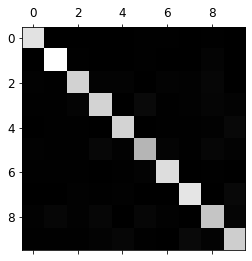

In [56]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

plt.matshow(conf_mx, cmap=plt.get_cmap("gray"))
plt.show()

大部分白色格子都在对角线上，说明图片基本上分类正确；格子越亮，分类准确率越高，我们看到5的格子要略暗一些，或者是5
的样本比较少，或者是分类器对该分类的效果不是很好。

9.下面观察分类错误的情况。

In [57]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

以上得到每种分类的样本总数，然后得到分类错误的比率（否则用数字对大分类不公平）。

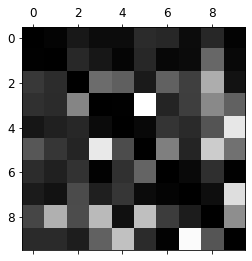

In [58]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.get_cmap("gray"))
plt.show()

以上先将对角线的值清0，然后显示错误分类的情况；格子颜色越亮，分类错误越严重。行代表分类本身，列代表预测分类。

我们看到，分类3很多被错误的识别为5，同时有一部分5被识别为了3。8和9的行比较亮，说明8和9的错误分类情况比较严重。
8和9的列比较亮，说明很多数字被错误分类成了8和9。

10.将部分3和5的样本打印出来。

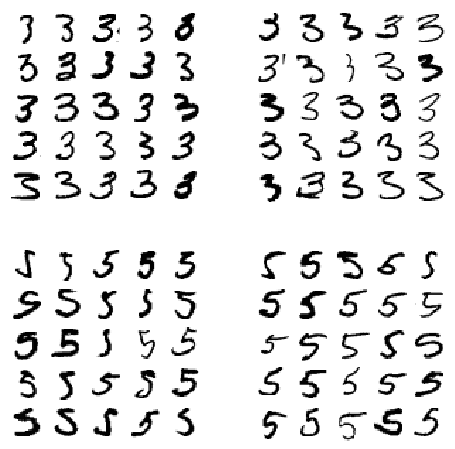

In [60]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.get_cmap("gray_r"), **options)
    plt.axis("off")

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

右边一列3和5是被分类错误的；3和5确实很像，但很多错误人眼就能识别出来，一方面SGD是线性分类器，3和5如果只有细微
的差别，它就不容易检测出来；另一方面可以对3和5的图片进行预处理，确保他们很好的中心化和不过度旋转，这样可以得到
比较好的分类效果。